In [ ]:
!wandb login

In [ ]:
import os, gc, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import librosa

from tqdm.notebook import tqdm
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import torch.nn.functional as F

import timm
from timm.models.vision_transformer import Block
from timm.models.layers import to_2tuple

from transformers import ASTFeatureExtractor

import wandb

# Define Config and Load data

In [ ]:
def get_logger(log_file='log.txt'):
    import logging
    import sys
    
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    # Logging to file
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    # Logging to console
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def wandb_init(project_name, run_name, config):
    config_dict = {
        k: v for k, v in config.__dict__.items() if not k.startswith('_') and not callable(v) and k != 'copy'
    }
    run = wandb.init(project=project_name, name=run_name, config=config_dict)
    return run

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.value = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
DRIVE_FOLDER = "." #"/content/drive/MyDrive/Colab Notebooks"
KEEP_COLS = ['category_number', 'common_name', 'audio_length', 'type', 'remarks', 'quality', 'scientific_name', 'mp3_link', 'region']

class Config:
    # path
    dataset_dir = f"{DRIVE_FOLDER}/Audio_XenoCanto"
    labels_list = f"{DRIVE_FOLDER}/xeno_labels.csv"
    model_name = "vitmae_pretrain"
    backbone_name = "hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k" #"MIT/ast-finetuned-audioset-10-10-0.4593"
    # number of classes in the dataset
    n_classes = 397 
    # Audio parameters
    audio_sr = 16000 #Hz
    segment_length = 10  #s
    fft_window = 0.025 #s
    hop_window_length = 0.01 #s
    n_mels = 128
    low_cut = 1000 #Hz
    high_cut = 8000 #Hz
    top_db = 100
    # Training parameters
    batch_size =  64 #16
    num_workers = 0
    n_splits = 5
    log_dir = f"{DRIVE_FOLDER}/training_logs"
    max_lr = 1e-5
    epochs = 10
    weight_decay = 0.01
    lr_final_div = 1000
    amp = True
    grad_accum_steps = 1
    max_grad_norm = 1e7
    print_epoch_freq = 1
    print_freq = 200
    # model parameters
    n_decoder_layers = 6
    n_decoder_heads = 6
    ff_dim_decoder = 2048
    # seed
    random_seed = 2046
    
    @classmethod
    def copy(cls):
        new_class = type('CustomConfig', (cls,), {k: v for k, v in cls.__dict__.items() if not k.startswith('__') and not callable(v)})
        return new_class
    
config = Config.copy()

if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

seed_everything(config.random_seed)

In [ ]:
df_audio_meta = pd.read_csv(f"{config.dataset_dir}/metadata.csv", nrows=None)
df_audio_meta = df_audio_meta.dropna().reset_index(drop=True)

# Filter out files that do not exist
df_audio_meta['file_exists'] = df_audio_meta['file_name'].apply(lambda x: os.path.exists(f"{config.dataset_dir}/{x}"))
df_audio_meta = df_audio_meta[df_audio_meta['file_exists']].reset_index(drop=True)

# parse scientific names
df_audio_meta['scientific_name'] = df_audio_meta['scientific_name'].apply(lambda x: "_".join(x.split(" ")))

# drop species with less than 2 samples
class_counts = df_audio_meta['scientific_name'].value_counts()
print(f"Number of classes with less than 2 samples: {len(class_counts[class_counts < 2])}")

df_audio_meta = df_audio_meta[df_audio_meta['scientific_name'].isin(class_counts[class_counts > 1].index)].copy().reset_index(drop=True)

# encode scientific names to label ids
label_ids_list = df_audio_meta['scientific_name'].unique().tolist()
label_ids_list.sort()
label_to_id = {label: i for i, label in enumerate(label_ids_list)}
df_audio_meta['species_id'] = df_audio_meta['scientific_name'].map(label_to_id)

# drop samples with no labels
df_audio_meta.dropna(subset=['species_id'], inplace=True)
df_audio_meta.reset_index(drop=True, inplace=True)
df_audio_meta['species_id'] = df_audio_meta['species_id'].astype(int)

print(f"Number of classes in dataset: {df_audio_meta['species_id'].nunique()}")
print(f'Number of samples:', len(df_audio_meta))

# save the number of classes in the config
config.n_classes = df_audio_meta['species_id'].nunique()

df_audio_meta.head(5)

# Models

In [ ]:
# Utils for positional embeddings
# --------------------------------------------------------
# 2D sine-cosine position embedding
# References:
# Transformer: https://github.com/tensorflow/models/blob/master/official/nlp/transformer/model_utils.py
# MoCo v3: https://github.com/facebookresearch/moco-v3
# --------------------------------------------------------

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_2d_sincos_pos_embed_flexible(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size[0], dtype=np.float32)
    grid_w = np.arange(grid_size[1], dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size[0], grid_size[1]])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

class PatchEmbed_org(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.patch_hw = (img_size[1] // patch_size[1], img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        #assert H == self.img_size[0] and W == self.img_size[1], \
        #    f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


In [ ]:
class ViTEncoder(nn.Module):
    
    def __init__(self, backbone_name, contextual_depth=8):
        super().__init__()
        self.backbone_model = timm.create_model(backbone_name, pretrained=True, num_classes=0)
        
        # desamble the backbone model
        self.patch_embed = getattr(self.backbone_model, 'patch_embed')
        self.cls_token = getattr(self.backbone_model, 'cls_token')
        self.pos_embed = getattr(self.backbone_model, 'pos_embed')
        self.blocks = getattr(self.backbone_model, 'blocks')
        self.norm = getattr(self.backbone_model, 'fc_norm')
        
        self.embed_dim = self.backbone_model.embed_dim
        self.num_patches = self.patch_embed.num_patches
        self.encoder_depth = len(self.blocks)
        self.contextual_depth=contextual_depth
        
        # Initialize weights
        self.initialize_weights()
        
    def initialize_weights(self):
        # Initialize the weights of each module using the backbone model's weights
        self._init_from_backbone(self.patch_embed, getattr(self.backbone_model, 'patch_embed'))
        self._init_from_backbone(self.cls_token, getattr(self.backbone_model, 'cls_token'))
        self._init_from_backbone(self.pos_embed, getattr(self.backbone_model, 'pos_embed'))
        self._init_from_backbone(self.blocks, getattr(self.backbone_model, 'blocks'))
        self._init_from_backbone(self.norm, getattr(self.backbone_model, 'fc_norm'))
    
    def _init_from_backbone(self, target, source):
        if isinstance(target, nn.Module):
            target.load_state_dict(source.state_dict())
        elif isinstance(target, torch.Tensor):
            target.data.copy_(source.data)
        else:
            raise TypeError("Unsupported type for weight initialization")
        
    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
        
    def forward(self, x, mask_ratio=0):
        
        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :]
        
        if mask_ratio > 0:
            x, mask, ids_restore = self.random_masking(x, mask_ratio)
        
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_token = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_token, x], dim=1)
        
        # apply Transformer blocks
        if mask_ratio > 0:
            for blk in self.blocks:
                x = blk(x)
            x = self.norm(x)
            
            return x, mask, ids_restore, None
        else:
            contextual_features = []
            for n, blk in enumerate(self.blocks):
                x = blk(x)
                if n >= self.contextual_depth:
                    contextual_features.append(self.norm(x))
            
            # -> [N, L=513, D=768]
            return torch.stack(contextual_features, dim=0).mean(dim=0)

In [ ]:
class ViTDecoder(nn.Module):
    
    def __init__(self, image_size, patch_size, in_chans, num_patches, encoder_dim, decoder_dim, num_layers, num_heads, ff_dim, pos_trainable=False):
        super().__init__()
        
        self.num_patches = num_patches
        self.in_chans = in_chans
        self.image_size = image_size if isinstance(image_size, (list, tuple)) else (image_size, image_size)
        self.patch_size = patch_size if isinstance(patch_size, (list, tuple)) else (patch_size, patch_size)
        self.patch_hw = (self.image_size[0] // self.patch_size[0], self.image_size[1] // self.patch_size[1])
        
        self.decoder_embed = nn.Linear(encoder_dim, decoder_dim, bias=True)
        
        self.mask_token = nn.Parameter(torch.randn(1, 1, decoder_dim))
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_dim), requires_grad=pos_trainable)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(
                dim=decoder_dim, num_heads=num_heads, qkv_bias=True, norm_layer=nn.LayerNorm
            )
            for _ in range(num_layers)
        ])
        
        self.decoder_norm = nn.LayerNorm(decoder_dim)
        self.decoder_pred = nn.Linear(decoder_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        
        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        decoder_pos_embed = get_2d_sincos_pos_embed_flexible(self.decoder_pos_embed.shape[-1], self.patch_hw, cls_token=True)
        
        print('decoder_pos_embed', decoder_pos_embed.shape, int(self.num_patches**.5))
        print('self.decoder_pos_embed', self.decoder_pos_embed.shape)
        
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed
        
        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        pred = self.decoder_pred(x)

        # remove cls token
        return pred, None, None #emb, emb_pixel

In [ ]:
class ViTMAE(nn.Module):
    
    def __init__(self, encoder_backbone, decoder_config, mask_ratio=0.75):
        super().__init__()
        self.enc_model = ViTEncoder(encoder_backbone)
        
        decoder_config['encoder_dim'] = self.enc_model.embed_dim
        decoder_config['num_patches'] = self.enc_model.num_patches
        
        self.dec_model = ViTDecoder(**decoder_config)
        
        self.image_size = self.dec_model.image_size
        self.patch_size = self.dec_model.patch_size
        self.in_chans = self.dec_model.in_chans
        self.mask_ratio = mask_ratio
        
    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        L = (H/p)*(W/p)
        """
        
        h = imgs.shape[2] // self.patch_size[0]
        w = imgs.shape[3] // self.patch_size[1]
        
        x = imgs.reshape(shape=(imgs.shape[0], 1, h, self.patch_size[0], w, self.patch_size[1]))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, self.patch_size[0]*self.patch_size[1]*self.in_chans))
        
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        specs: (N, 1, H, W)
        """
        h = self.image_size[0] // self.patch_size[0]
        w = self.image_size[1] // self.patch_size[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, self.patch_size[0], self.patch_size[1], self.in_chans))
        x = torch.einsum('nhwpqc->nchpwq', x)
        specs = x.reshape(shape=(x.shape[0], 1, h*self.patch_size[0], w*self.patch_size[1]))
        return specs
    
    def forward_loss(self, imgs, pred, mask, norm_pix_loss=False):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss   
        
    def forward(self, x):
        encode_x, mask, ids_restore, _ = self.enc_model(x, self.mask_ratio)
        pred, _, _ = self.dec_model(encode_x, ids_restore)
        pred = pred[:, 1:, :]
        reconstruct_loss = self.forward_loss(x, pred, mask, norm_pix_loss=False)
        
        return reconstruct_loss, pred, mask, ids_restore

In [ ]:
# # test models
# test_input = torch.randn(1, 1, 1024, 128)

# # test ViTEncoder
# backbone_name = "hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k"
# enc_model = ViTEncoder(backbone_name)
# encode_x, mask, ids_restore, _ = enc_model(test_input, 0.75)
# print(encode_x.shape, mask.shape, ids_restore.shape)

# # test ViTDecoder
# decoder_config = dict(
#     image_size=(1024, 128),
#     patch_size=16, 
#     in_chans=1, 
#     decoder_dim=768, 
#     num_layers=8, 
#     num_heads=12, 
#     ff_dim=2048
# )
# decode_model = ViTDecoder(**decoder_config, encoder_dim=enc_model.embed_dim, num_patches=enc_model.num_patches)
# pred, _, _ = decode_model(encode_x, ids_restore)
# print(pred.shape)

# # test ViTMAE
# vitmae_model = ViTMAE(backbone_name, decoder_config, mask_ratio=0.75)
# reconstruct_loss, pred, mask, ids_restore = vitmae_model(test_input)
# print(reconstruct_loss, pred.shape, mask.shape, ids_restore.shape)

# Dataset

In [ ]:
class BirdSongDataset(Dataset):
    
    def __init__(self, df_audio_meta, config):
        self.df_audio_meta = df_audio_meta
        self.feature_extractor = ASTFeatureExtractor()
        self.config = config
    
    def __len__(self):
        return len(self.df_audio_meta)

    def __getitem__(self, idx):
        row = self.df_audio_meta.iloc[idx]
        audio_path = f"{self.config.dataset_dir}/{row['file_name']}"
        audio_arr, sr = self.get_audio(audio_path)
        spec = self.feature_extractor(audio_arr, sampling_rate=sr, padding="max_length", return_tensors="pt")
        return spec['input_values'].squeeze(0), row['species_id']

    def get_audio(self, audio_path):
        audio, sr = librosa.load(audio_path, sr=self.config.audio_sr)
        return audio, sr

def collate_fn(batch):
    inputs = [x[0] for x in batch]
    targets = [x[1] for x in batch]
    data_dict = {
        "input_ids": torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0),
        "labels": torch.tensor(targets)
    }
    return data_dict

In [ ]:
# training loop
# train the BirdASTForPretrain with self-supervised learning

bs_dataset = BirdSongDataset(df_audio_meta, config)
bs_dataloader = DataLoader(bs_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

backbone_name = config.backbone_name

decoder_config = dict(
    image_size=(1024, 128),
    patch_size=16, 
    in_chans=1, 
    decoder_dim=768, 
    num_layers=8, 
    num_heads=12, 
    ff_dim=2048
)

vitmae_model = ViTMAE(backbone_name, decoder_config, mask_ratio=0.75)
vitmae_model.to(DEVICE)

optimizer = AdamW(vitmae_model.parameters(), lr=config.max_lr, weight_decay=config.weight_decay)
scheduler = OneCycleLR(
    optimizer, 
    max_lr=config.max_lr, 
    final_div_factor=config.lr_final_div, 
    steps_per_epoch=len(bs_dataloader), 
    epochs=config.epochs
    )

scaler = GradScaler(enabled=config.amp)

loss_records = defaultdict(list)

wandb_init(config.model_name, config.model_name, config)
logger = get_logger(f"{config.log_dir}/BirdAST_Pretrain.log")

best_loss = np.inf

for epoch in range(config.epochs):
    
    loss_meter = AverageMeter()
    
    for i, batch in tqdm(enumerate(bs_dataloader), total=len(bs_dataloader)):
        
        spectrograms = batch['input_ids'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        
        optimizer.zero_grad()
        
        with autocast(enabled=config.amp):
            loss, pred, mask, ids_restore = vitmae_model(spectrograms.unsqueeze(1))
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step()
        
        loss_meter.update(loss.item())
        
        wandb.log({"Loss": loss.item(), "Learning Rate": scheduler.get_last_lr()[0], "Epoch": epoch, "Batch": i})
        
        if i % config.print_freq == 0:
            logger.info(f"Epoch: {epoch} | Batch: {i}, Loss: {loss_meter.avg}")
            
    wandb.log({"Epoch_Loss": loss_meter.avg, "Epoch": epoch})
    loss_records[f'epoch_{i+1}'].append(loss_meter.avg)
    logger.info('-'*10 + "\n" + f"Epoch: {epoch} | Loss: {loss_meter.avg}" + "\n" + '-'*10)
    
    # save model
    model_path = f"{config.log_dir}/ViTMAE_Pretrain_best_{loss_meter.avg:.2f}.pth"
    if loss_meter.avg < best_loss:
        best_loss = loss_meter.avg
        torch.save(vitmae_model.state_dict(), model_path)
        logger.info(f"Best Model loss = {loss_meter.avg} | saved at: {model_path}")
        
    # clear memory
    del spectrograms, labels, pred
    gc.collect()
    torch.cuda.empty_cache()
    
    

In [43]:
# view model results

backbone_name = config.backbone_name

decoder_config = dict(
    image_size=(1024, 128),
    patch_size=16, 
    in_chans=1, 
    decoder_dim=768, 
    num_layers=8, 
    num_heads=12, 
    ff_dim=2048
)

vitmae_model = ViTMAE(backbone_name, decoder_config, mask_ratio=0.75)

model_weights = "./training_logs/ViTMAE_Pretrain_best_0.47.pth"

# load weights
vitmae_model.load_state_dict(torch.load(model_weights, map_location=DEVICE))
vitmae_model.to(DEVICE)

# test the model

for i, batch in tqdm(enumerate(bs_dataloader), total=len(bs_dataloader)):
    
    spectrograms = batch['input_ids'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)
    
    with torch.no_grad():
        reconstruct_loss, pred, mask, ids_restore = vitmae_model(spectrograms.unsqueeze(1))
    
    break

Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)
decoder_pos_embed (513, 768) 22
self.decoder_pos_embed torch.Size([1, 513, 768])


  0%|          | 0/699 [00:00<?, ?it/s]

In [44]:
spec_patches = vitmae_model.patchify(spectrograms.unsqueeze(1))

# apply mask to the patches, use zero for removed patches
spec_patches[mask == 1] = 0

specs_masked = vitmae_model.unpatchify(spec_patches)

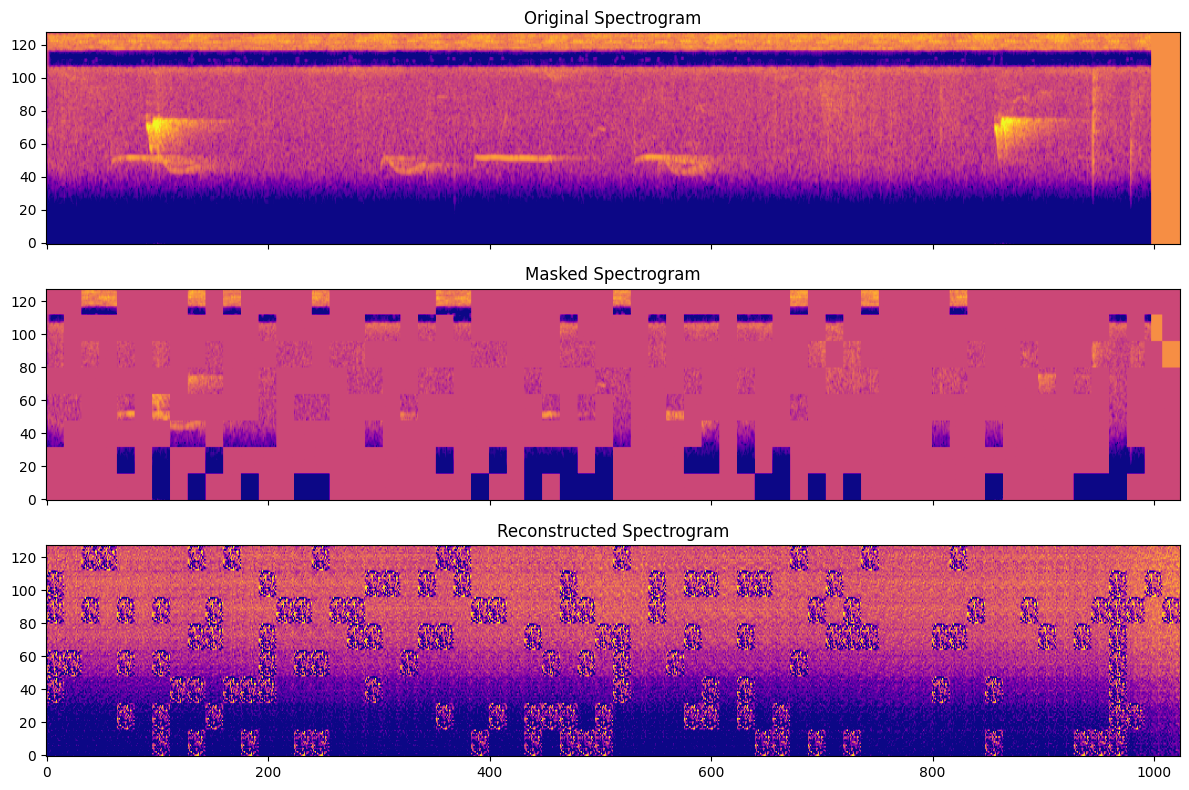

In [45]:
reconstructed = vitmae_model.unpatchify(pred) # [N, 1, H, W]

spec_id = 12

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)
imshow_kwargs = dict(aspect='auto', cmap='plasma', vmax=1, vmin=-1, origin='lower')

ax = axes[0]
ax.imshow(spectrograms[spec_id].detach().cpu().numpy().T, **imshow_kwargs)
ax.set_title(f"Original Spectrogram")

ax = axes[1]
ax.imshow(specs_masked[spec_id].detach().cpu().numpy().squeeze(0).T, **imshow_kwargs)
ax.set_title(f"Masked Spectrogram")

ax = axes[2]
ax.imshow(reconstructed[spec_id].detach().cpu().numpy().squeeze(0).T, **imshow_kwargs)
ax.set_title(f"Reconstructed Spectrogram")

fig.tight_layout()
plt.show()